In [48]:
import torch 
from torch import nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import os,PIL,pathlib
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

#设置GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
data_dir = './data/bird_photos'
data_dir = pathlib.Path(data_dir)

In [11]:
image_count = len(list(data_dir.glob('*/*')))
image_count # 这里输出的是图片的总数

565

In [12]:
data_dir = './data/bird_photos'
data_transform = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.ToTensor()
])

In [17]:
total_data = datasets.ImageFolder(data_dir,transform=data_transform)
total_data

Dataset ImageFolder
    Number of datapoints: 565
    Root location: ./data/bird_photos
    StandardTransform
Transform: Compose(
               Resize(size=[224, 224], interpolation=bilinear)
               ToTensor()
           )

In [39]:
class_names = total_data.classes
class_names

['Bananaquit', 'Black Skimmer', 'Black Throated Bushtiti', 'Cockatoo']

In [28]:
train_size = int(0.8*len(total_data))
test_size = len(total_data) - train_size
train_data,test_data = torch.utils.data.random_split(total_data,[train_size,test_size])

In [29]:
train_size,test_size

(452, 113)

In [30]:
batch_size = 8
train_dl = torch.utils.data.DataLoader(train_data,batch_size=batch_size,shuffle=True)
test_dl = torch.utils.data.DataLoader(test_data,batch_size=batch_size)

In [51]:
# 检查一下数据
for X, y in test_dl:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([8, 3, 224, 224])
Shape of y:  torch.Size([8]) torch.int64


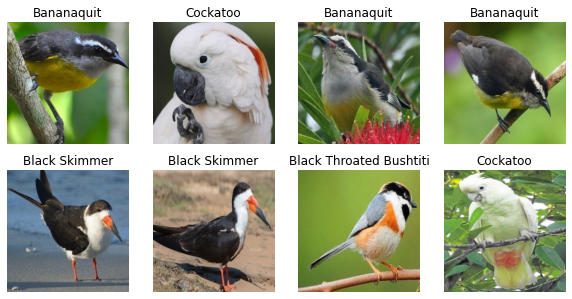

In [50]:
plt.figure(figsize=(10,5))
plt.title("查看数据")
for images,labels in train_dl:
    for i in range(8):
        ax = plt.subplot(2,4,i+1)
        plt.imshow(images[i].permute(1,2,0))
        #使用matplotlib显示彩色图像需要数据的维度为 【width, height, channel】，就是224 * 224 * 3
        #报错原因是我这里的tensor的维度为 3 * 224 * 224,所以需要使用permute函数
        plt.title(class_names[labels[i]])
        plt.axis("off")
    break

In [70]:
# 定义identity模块
class identity_block(nn.Module):
    def __init__(self,in_channels,outs,kernel_size,stride,padding):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels,outs[0],kernel_size=kernel_size[0],stride=stride[0],padding=padding[0])
        self.bn1 = nn.BatchNorm2d(outs[0])
        self.conv2 = nn.Conv2d(outs[0],outs[1],kernel_size=kernel_size[1],stride=stride[1],padding=padding[1])
        self.bn2 = nn.BatchNorm2d(outs[1])
        self.conv3 = nn.Conv2d(outs[1],outs[2],kernel_size=kernel_size[2],stride=stride[2],padding=padding[2])
        self.bn3 = nn.BatchNorm2d(outs[2])
    def forward(self,x):
        out = self.conv1(x)
        out = F.relu(self.bn1(out))
        out = self.conv2(out)
        out = F.relu(self.bn2(out))
        out = self.conv3(out)
        out = self.bn3(out)
        return F.relu(out + x)

In [81]:
# 定义conv_block模块
class conv_block(nn.Module):
    def __init__(self,in_channels,outs,kernel_size,stride,padding):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels,outs[0],kernel_size=kernel_size[0],stride=stride[0],padding=padding[0])
        self.bn1 = nn.BatchNorm2d(outs[0])
        self.conv2 = nn.Conv2d(outs[0],outs[1],kernel_size=kernel_size[1],stride=stride[1],padding=padding[1])
        self.bn2 = nn.BatchNorm2d(outs[1])
        self.conv3 = nn.Conv2d(outs[1],outs[2],kernel_size=kernel_size[2],stride=stride[2],padding=padding[2])
        self.bn3 = nn.BatchNorm2d(outs[2])
        
        self.extra = nn.Sequential(
            nn.Conv2d(in_channels, outs[2], kernel_size=1, stride=stride[3], padding=0),
            nn.BatchNorm2d(outs[2])
        )
    def forward(self,x):
        x_shortcut = self.extra(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = F.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)
        return F.relu(out+x_shortcut)

In [84]:
class ResNet50(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,64,kernel_size=7,padding=3)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = nn.Sequential(
            conv_block(64, outs=[64, 64, 256], kernel_size=[1, 3, 1], stride=[1, 1, 1, 1], padding=[0, 1, 0]),
            identity_block(256, outs=[64, 64, 256], kernel_size=[1, 3, 1], stride=[1, 1, 1, 1], padding=[0, 1, 0]),
            identity_block(256, outs=[64, 64, 256], kernel_size=[1, 3, 1], stride=[1, 1, 1, 1], padding=[0, 1, 0]),
        )
        
        self.layer2 = nn.Sequential(
            conv_block(256, outs=[128, 128, 512], kernel_size=[1, 3, 1], stride=[1, 2, 1, 2], padding=[0, 1, 0]),
            identity_block(512, outs=[128, 128, 512], kernel_size=[1, 3, 1], stride=[1, 1, 1, 1], padding=[0, 1, 0]),
            identity_block(512, outs=[128, 128, 512], kernel_size=[1, 3, 1], stride=[1, 1, 1, 1], padding=[0, 1, 0]),
            conv_block(512, outs=[128, 128, 512], kernel_size=[1, 3, 1], stride=[1, 1, 1, 1], padding=[0, 1, 0])
        )

        self.layer3 = nn.Sequential(
            conv_block(512, outs=[256, 256, 1024], kernel_size=[1, 3, 1], stride=[1, 2, 1, 2], padding=[0, 1, 0]),
            identity_block(1024, outs=[256, 256, 1024], kernel_size=[1, 3, 1], stride=[1, 1, 1, 1],
                               padding=[0, 1, 0]),
            identity_block(1024, outs=[256, 256, 1024], kernel_size=[1, 3, 1], stride=[1, 1, 1, 1],
                               padding=[0, 1, 0]),
            conv_block(1024, outs=[256, 256, 1024], kernel_size=[1, 3, 1], stride=[1, 1, 1, 1],
                              padding=[0, 1, 0]),
            conv_block(1024, outs=[256, 256, 1024], kernel_size=[1, 3, 1], stride=[1, 1, 1, 1],
                              padding=[0, 1, 0]),
            conv_block(1024, outs=[256, 256, 1024], kernel_size=[1, 3, 1], stride=[1, 1, 1, 1],
                              padding=[0, 1, 0])
        )

        self.layer4 = nn.Sequential(
            conv_block(1024, outs=[512, 512, 2048], kernel_size=[1, 3, 1], stride=[1, 2, 1, 2],
                              padding=[0, 1, 0]),
            conv_block(2048, outs=[512, 512, 2048], kernel_size=[1, 3, 1], stride=[1, 1, 1, 1],
                              padding=[0, 1, 0]),
            conv_block(2048, outs=[512, 512, 2048], kernel_size=[1, 3, 1], stride=[1, 1, 1, 1],
                              padding=[0, 1, 0])
        )
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

        self.fc = nn.Linear(2048,4)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.reshape(x.shape[0], -1)
        out = self.fc(out)
        return out

In [86]:
# 定义完成，测试一下
x = torch.randn(2, 3, 224, 224)
model = ResNet50()
out = model(x)
print('out.shape: ', out.shape)
print(out)

out.shape:  torch.Size([2, 4])
tensor([[-0.4019,  0.1340, -0.1497,  0.7739],
        [-0.4633,  0.1125, -0.1887,  0.6579]], grad_fn=<AddmmBackward>)


In [96]:
model.to(device)
# 统计模型参数量以及其他指标
import torchsummary as summary
summary.summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           9,472
         MaxPool2d-2         [-1, 64, 112, 112]               0
            Conv2d-3        [-1, 256, 112, 112]          16,640
       BatchNorm2d-4        [-1, 256, 112, 112]             512
            Conv2d-5         [-1, 64, 112, 112]           4,160
       BatchNorm2d-6         [-1, 64, 112, 112]             128
            Conv2d-7         [-1, 64, 112, 112]          36,928
       BatchNorm2d-8         [-1, 64, 112, 112]             128
            Conv2d-9        [-1, 256, 112, 112]          16,640
      BatchNorm2d-10        [-1, 256, 112, 112]             512
       conv_block-11        [-1, 256, 112, 112]               0
           Conv2d-12         [-1, 64, 112, 112]          16,448
      BatchNorm2d-13         [-1, 64, 112, 112]             128
           Conv2d-14         [-1, 64, 1

In [97]:
# 训练循环
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)  # 训练集的大小
    num_batches = len(dataloader)   # 批次数目, (size/batch_size，向上取整)

    train_loss, train_acc = 0, 0  # 初始化训练损失和正确率
    
    for X, y in dataloader:  # 获取图片及其标签
        X, y = X.to(device), y.to(device)
        
        # 计算预测误差
        pred = model(X)          # 网络输出
        loss = loss_fn(pred, y)  # 计算网络输出和真实值之间的差距，targets为真实值，计算二者差值即为损失
        
        # 反向传播
        optimizer.zero_grad()  # grad属性归零
        loss.backward()        # 反向传播
        optimizer.step()       # 每一步自动更新
        
        # 记录acc与loss
        train_acc  += (pred.argmax(1) == y).type(torch.float).sum().item()
        train_loss += loss.item()
            
    train_acc  /= size
    train_loss /= num_batches

    return train_acc, train_loss

In [100]:
def test (dataloader, model, loss_fn):
    size        = len(dataloader.dataset)  # 测试集的大小
    num_batches = len(dataloader)          # 批次数目, (size/batch_size，向上取整)
    test_loss, test_acc = 0, 0
    
    # 当不进行训练时，停止梯度更新，节省计算内存消耗
    with torch.no_grad():
        for imgs, target in dataloader:
            imgs, target = imgs.to(device), target.to(device)
            
            # 计算loss
            target_pred = model(imgs)
            loss        = loss_fn(target_pred, target)
            
            test_loss += loss.item()
            test_acc  += (target_pred.argmax(1) == target).type(torch.float).sum().item()

    test_acc  /= size
    test_loss /= num_batches

    return test_acc, test_loss

In [ ]:
import copy

optimizer  = torch.optim.Adam(model.parameters(), lr= 1e-4)
loss_fn    = nn.CrossEntropyLoss() # 创建损失函数

epochs     = 10

train_loss = []
train_acc  = []
test_loss  = []
test_acc   = []

best_acc = 0    # 设置一个最佳准确率，作为最佳模型的判别指标

for epoch in range(epochs):
    
    model.train()
    epoch_train_acc, epoch_train_loss = train(train_dl, model, loss_fn, optimizer)
    
    model.eval()
    epoch_test_acc, epoch_test_loss = test(test_dl, model, loss_fn)
    
    # 保存最佳模型到 best_model
    if epoch_test_acc > best_acc:
        best_acc   = epoch_test_acc
        best_model = copy.deepcopy(model)
    
    train_acc.append(epoch_train_acc)
    train_loss.append(epoch_train_loss)
    test_acc.append(epoch_test_acc)
    test_loss.append(epoch_test_loss)
    
    # 获取当前的学习率
    lr = optimizer.state_dict()['param_groups'][0]['lr']
    
    template = ('Epoch:{:2d}, Train_acc:{:.1f}%, Train_loss:{:.3f}, Test_acc:{:.1f}%, Test_loss:{:.3f}, Lr:{:.2E}')
    print(template.format(epoch+1, epoch_train_acc*100, epoch_train_loss, 
                          epoch_test_acc*100, epoch_test_loss, lr))
    
# 保存最佳模型到文件中
PATH = './best_model.pth'  # 保存的参数文件名
torch.save(model.state_dict(), PATH)

print('Done')

Epoch: 1, Train_acc:67.9%, Train_loss:0.904, Test_acc:73.5%, Test_loss:0.842, Lr:1.00E-04
Epoch: 2, Train_acc:73.2%, Train_loss:0.697, Test_acc:73.5%, Test_loss:0.821, Lr:1.00E-04
Epoch: 3, Train_acc:78.1%, Train_loss:0.618, Test_acc:69.9%, Test_loss:1.016, Lr:1.00E-04
Epoch: 4, Train_acc:79.2%, Train_loss:0.589, Test_acc:76.1%, Test_loss:0.558, Lr:1.00E-04
Epoch: 5, Train_acc:81.0%, Train_loss:0.474, Test_acc:78.8%, Test_loss:0.535, Lr:1.00E-04
Epoch: 6, Train_acc:84.7%, Train_loss:0.458, Test_acc:85.0%, Test_loss:0.492, Lr:1.00E-04
Epoch: 7, Train_acc:86.1%, Train_loss:0.386, Test_acc:85.0%, Test_loss:0.533, Lr:1.00E-04
Epoch: 8, Train_acc:85.4%, Train_loss:0.392, Test_acc:88.5%, Test_loss:0.463, Lr:1.00E-04
Epoch: 9, Train_acc:87.6%, Train_loss:0.377, Test_acc:85.8%, Test_loss:0.394, Lr:1.00E-04


In [ ]:
import matplotlib.pyplot as plt
#隐藏警告
import warnings
warnings.filterwarnings("ignore")               #忽略警告信息
plt.rcParams['font.sans-serif']    = ['SimHei'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False      # 用来正常显示负号
plt.rcParams['figure.dpi']         = 100        #分辨率

epochs_range = range(epochs)

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, test_acc, label='Test Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, test_loss, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()